In [195]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import statsmodels.formula.api as smf
import datetime

# Data

In [196]:
df = pd.read_csv('final_project_data.csv', parse_dates = True, index_col = 0)
df.tail(15)

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,US Industrial Index,UK industrial Index
Date,,,,,,
2023-12-12,4.732,4.506,NaN,3.1,NaN,NaN
2023-12-13,4.429,4.365,NaN,NaN,NaN,NaN
2023-12-14,4.389,4.327,NaN,NaN,NaN,NaN
2023-12-15,4.446,4.267,NaN,NaN,NaN,NaN
2023-12-18,4.447,4.296,NaN,NaN,102.4301,93.9
2023-12-19,4.441,4.265,NaN,NaN,NaN,NaN
2023-12-20,4.333,4.089,3.9,NaN,NaN,NaN
2023-12-21,4.348,4.044,NaN,NaN,NaN,NaN
2023-12-22,4.324,4.030,NaN,NaN,NaN,NaN


<Axes: >

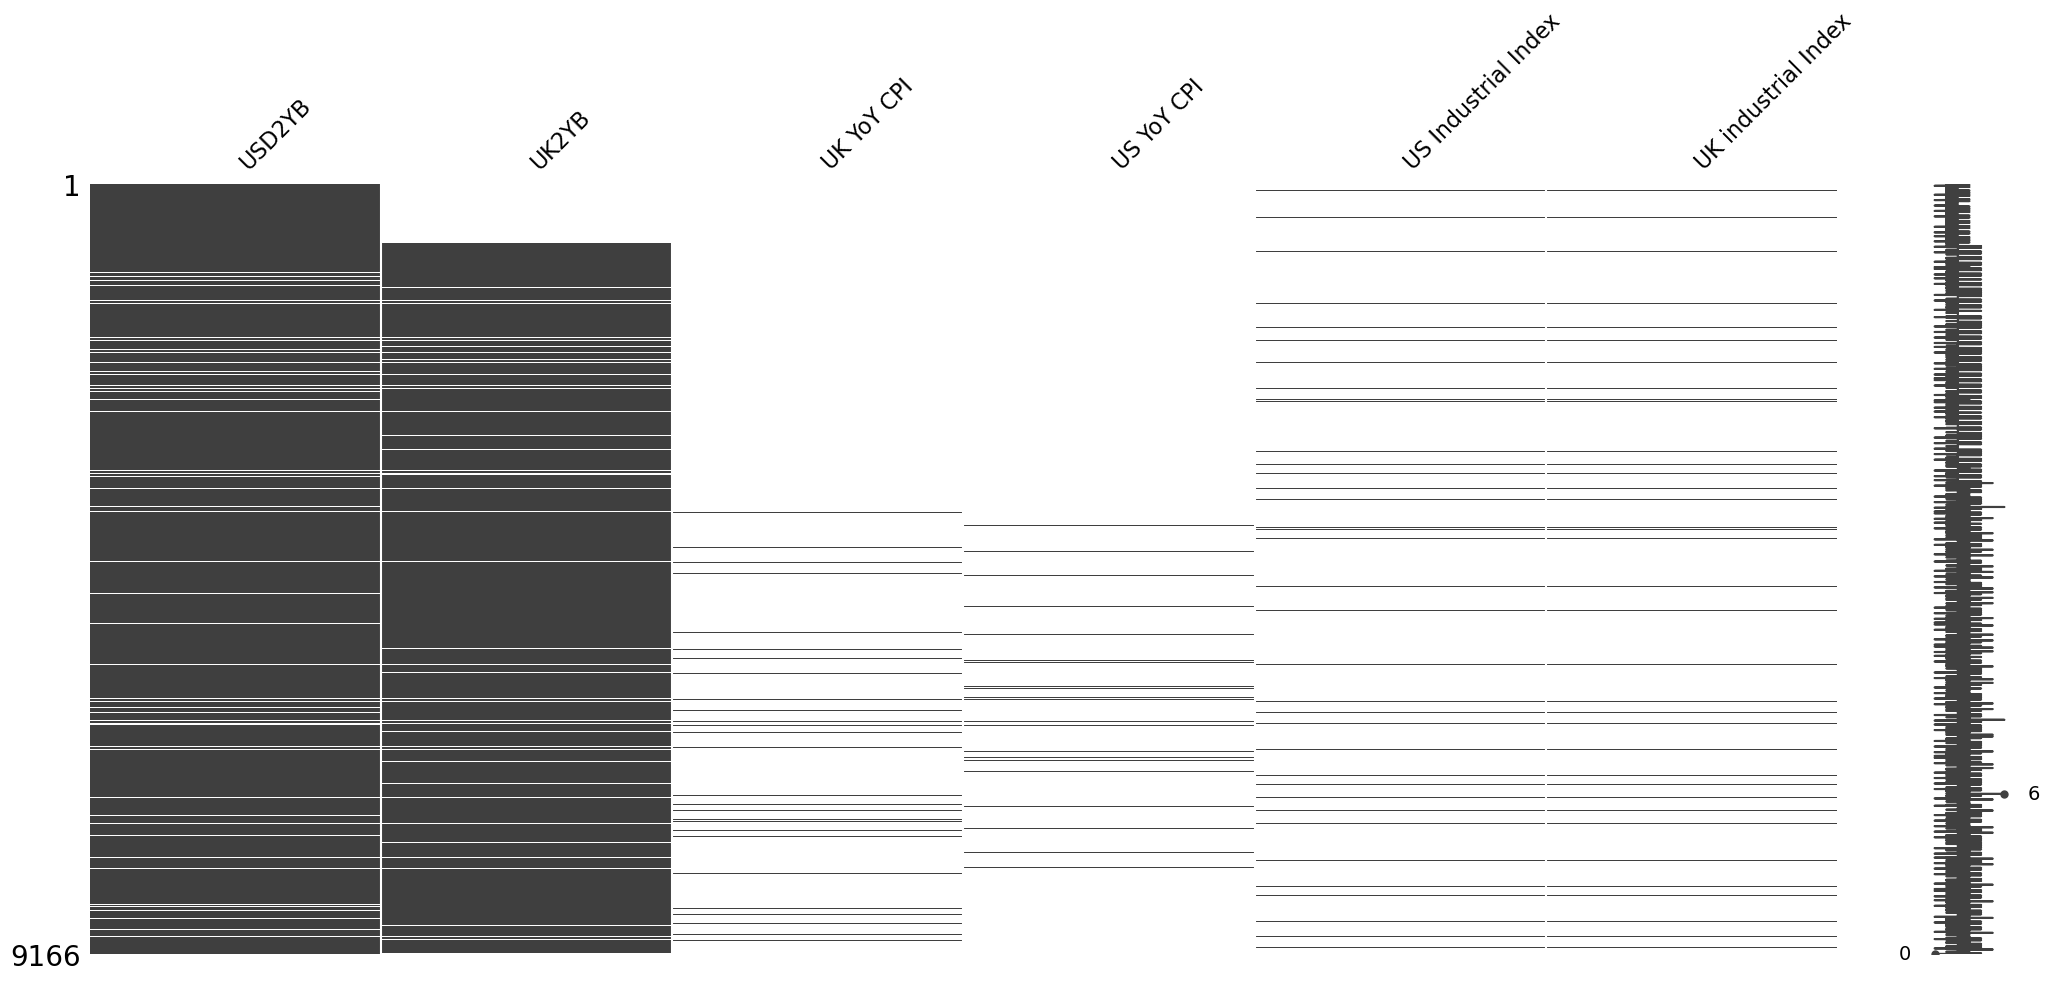

In [197]:
# im gonna see all the missing values in the data
import missingno as msno
msno.matrix(df)

In [198]:
#we find the first value of CPI in order the delet the NaN values that are before that date
initial_date = df['UK YoY CPI'].first_valid_index() 
#.fist_valid_index() returns the first non-NaN value
initial_date

Timestamp('2003-06-17 00:00:00')

In [199]:
#im gonna transform initial_date to first day of the last month 
initial_date = initial_date.replace(day=1)
#We reduce 1 month to this date
initial_date = initial_date - pd.DateOffset(months=1)
initial_date

Timestamp('2003-05-01 00:00:00')

In [200]:
#Lets transform the date to a string, keeping the format YYYY-DD-MM
initial_date_2 = initial_date.strftime('%Y-%m-%d')
initial_date_2

'2003-05-01'

In [201]:
ticker = "USDGBP=X"
usd_to_gbp_rate = yf.download(ticker, start=initial_date_2, end=df.index[-1].strftime('%Y-%m-%d'))

[*********************100%%**********************]  1 of 1 completed


In [202]:
#we are gonna drop all the values before initial_date
df = df[initial_date:]
df.head()

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,US Industrial Index,UK industrial Index
Date,,,,,,
2003-05-01,1.469,3.572,NaN,NaN,NaN,NaN
2003-05-02,1.565,3.631,NaN,NaN,NaN,NaN
2003-05-05,1.533,NaN,NaN,NaN,NaN,NaN
2003-05-06,1.428,3.644,NaN,NaN,NaN,NaN
2003-05-07,1.412,3.585,NaN,NaN,NaN,NaN


In [203]:
#Im gonna try transform USD2YB and UK2YB to a daily frequency
df['USD2YB'] = ((df['USD2YB']/100)+1)**(1/126)
df['UK2YB'] = ((df['UK2YB']/100)+1)**(1/126)

In [204]:
#Im gonna transform the USD2YB and UK2YB to a log return
df['USD2YB'] = np.log(df['USD2YB'])
df['UK2YB'] = np.log(df['UK2YB'])


In [205]:
nan_values = df.isnull().sum()
print("NaN values in each column:")
print(nan_values)



NaN values in each column:
USD2YB                  299
UK2YB                   246
UK YoY CPI             5221
US YoY CPI             5220
US Industrial Index    5219
UK industrial Index    5220
dtype: int64


In [206]:
#Im gonna calculate the log return of the exchange rate
usd_to_gbp_rate = usd_to_gbp_rate.copy()

usd_to_gbp_rate['log_return'] = np.log(usd_to_gbp_rate['Adj Close']) - np.log(usd_to_gbp_rate['Adj Close'].shift(1))
#were gonna drop the first value of the log return
usd_to_gbp_rate = usd_to_gbp_rate.dropna()
#we keep only the columns Adj Close and log_return
usd_to_gbp_rate = usd_to_gbp_rate[['Adj Close', 'log_return']]

In [207]:
initial_date_3 = usd_to_gbp_rate['Adj Close'].first_valid_index() 
initial_date_3

Timestamp('2003-12-02 00:00:00')

In [208]:
df = df.merge(usd_to_gbp_rate["log_return"], left_index=True, right_index=True, how='left')

In [209]:
df.tail(15)

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,US Industrial Index,UK industrial Index,log_return
Date,,,,,,,
2023-12-12,0.000367,0.000350,NaN,3.1,NaN,NaN,0.000013
2023-12-13,0.000344,0.000339,NaN,NaN,NaN,NaN,-0.001281
2023-12-14,0.000341,0.000336,NaN,NaN,NaN,NaN,-0.004144
2023-12-15,0.000345,0.000332,NaN,NaN,NaN,NaN,-0.011694
2023-12-18,0.000345,0.000334,NaN,NaN,102.4301,93.9,0.007786
2023-12-19,0.000345,0.000331,NaN,NaN,NaN,NaN,0.001621
2023-12-20,0.000337,0.000318,3.9,NaN,NaN,NaN,-0.006371
2023-12-21,0.000338,0.000315,NaN,NaN,NaN,NaN,0.007206
2023-12-22,0.000336,0.000314,NaN,NaN,NaN,NaN,-0.003453


In [210]:
#Im gonna resample the data to a monthly frequency. For USD2YB and UK2YB we are gonna use the sum of the log returns, and for the rest of the columns we are gonna use the last value of the month.

df2 = df.resample('M').agg({'USD2YB':'sum', 'UK2YB':'sum', 'UK YoY CPI':'last', 'US YoY CPI':'last', 'UK industrial Index':'last', 'US Industrial Index':'last', 'log_return':'sum'})
df2

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,UK industrial Index,US Industrial Index,log_return
Date,,,,,,,
2003-05-31,0.002300,0.005518,NaN,2.2,101.1,90.4281,0.000000
2003-06-30,0.002001,0.005601,1.2,2.1,99.8,90.4073,0.000000
2003-07-31,0.002527,0.006387,1.1,2.1,100.4,90.5218,0.000000
2003-08-31,0.003007,0.006292,1.3,2.1,101.0,90.9896,0.000000
2003-09-30,0.002777,0.007110,1.4,2.2,101.2,90.7858,0.000000
...,...,...,...,...,...,...,...
2023-09-30,0.007813,0.008113,6.7,3.7,95.0,103.2411,0.040701
2023-10-31,0.008264,0.008272,6.7,3.7,94.9,103.3346,0.003205
2023-11-30,0.007962,0.007883,4.6,3.2,93.7,102.4592,-0.042694


In [211]:
# Specify the columns to be shifted
columns_to_shift = ['UK YoY CPI', 'US YoY CPI', 'US Industrial Index', 'UK industrial Index']

# Shift the specified columns using .shift(-1)
df2[columns_to_shift] = df2[columns_to_shift].shift(-1)

# Display the resulting DataFrame with shifted columns
df2

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,UK industrial Index,US Industrial Index,log_return
Date,,,,,,,
2003-05-31,0.002300,0.005518,1.2,2.1,99.8,90.4073,0.000000
2003-06-30,0.002001,0.005601,1.1,2.1,100.4,90.5218,0.000000
2003-07-31,0.002527,0.006387,1.3,2.1,101.0,90.9896,0.000000
2003-08-31,0.003007,0.006292,1.4,2.2,101.2,90.7858,0.000000
2003-09-30,0.002777,0.007110,1.4,2.3,101.4,91.3829,0.000000
...,...,...,...,...,...,...,...
2023-09-30,0.007813,0.008113,6.7,3.7,94.9,103.3346,0.040701
2023-10-31,0.008264,0.008272,4.6,3.2,93.7,102.4592,0.003205
2023-11-30,0.007962,0.007883,3.9,3.1,93.9,102.4301,-0.042694


In [212]:
#we get rid of the last two rows of the dataframes
df2 = df2[:-2]

In [213]:
df2.isnull().sum()

USD2YB                 0
UK2YB                  0
UK YoY CPI             0
US YoY CPI             0
UK industrial Index    0
US Industrial Index    0
log_return             0
dtype: int64

# Strategy